<a href="https://colab.research.google.com/github/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/13-Classifica%C3%A7%C3%A3o_Fashion_CNN_WideResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

2025-05-19 19:53:16.361678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747695196.400482   15894 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747695196.404701   15894 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 19:53:16.455986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sklearn: 1.6.1
tensorflow: 2.18.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
print ( gpus )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_model = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
    model_path = "keras_model.keras"
    scaler_path = "standard_scaler.joblib"

### Amostra FASHION MNIST

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:10000], X_train_full[10000:]
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]

tf.random.set_seed(42)
np.random.seed(42)

print ( X_train.shape )
print ( X_valid.shape )
print ( X_test.shape )

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [5]:
X_train = X_train.reshape( (len(X_train),28,28,1) )
print( X_train.shape )
X_valid = X_valid.reshape( (len(X_valid),28,28,1) )
print( X_valid.shape )
X_test = X_test.reshape( (len(X_test),28,28,1) )
print( X_test.shape )

X_mean = X_train.mean( axis=0 )
X_std = X_train.std( axis=0 )
X_train_scaled = ( X_train - X_mean ) / X_std
X_valid_scaled = ( X_valid - X_mean ) / X_std
X_test_scaled  = ( X_test - X_mean ) / X_std
X_train_scaled[10]

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


array([[[-0.00714939],
        [-0.02259701],
        [-0.04749068],
        [-0.04039468],
        [-0.05683006],
        [-0.07010959],
        [-0.09760359],
        [-0.15513164],
        [-0.23893762],
        [-0.37952352],
        [-0.57053077],
        [-0.694674  ],
        [-0.75900494],
        [-0.74973597],
        [-0.74937949],
        [-0.7751858 ],
        [-0.75745513],
        [-0.64652364],
        [-0.50360013],
        [-0.31979054],
        [-0.20224307],
        [-0.13951541],
        [-0.10889008],
        [-0.09206532],
        [-0.06849855],
        [-0.0507646 ],
        [-0.03324326],
        [-0.01443135]],

       [[-0.01230748],
        [-0.0168835 ],
        [-0.03319486],
        [-0.05559106],
        [-0.07714261],
        [-0.13124202],
        [-0.24326328],
        [-0.36492659],
        [-0.48893735],
        [-0.6445122 ],
        [-0.8337121 ],
        [-1.00353902],
        [-1.09301419],
        [-1.0837614 ],
        [-1.06800491],
        [

In [6]:
print ( y_train )

[8 7 6 ... 3 0 5]


In [7]:
import keras.utils

number_of_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, number_of_classes)
y_valid_cat = keras.utils.to_categorical(y_valid, number_of_classes)
y_test_cat = keras.utils.to_categorical(y_test, number_of_classes)
# y_train_cat = keras.utils.np_utils.to_categorical(y_train, number_of_classes)
# y_valid_cat = keras.utils.np_utils.to_categorical(y_valid, number_of_classes)
# y_test_cat = keras.utils.np_utils.to_categorical(y_test, number_of_classes)

idx=1000
y_train[idx], y_train_cat[idx]

(np.uint8(8), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] Bag


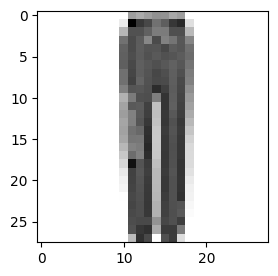

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print ( y_train[ idx ], y_train_cat[ idx ], class_names[ y_train[ idx ] ] )

fig = plt.figure( figsize=(3,3) )
plt.imshow( X_valid[ idx ], cmap='binary' )

### Treinamento

In [9]:
# shuffle_index = np.random.permutation( 50000 )
# X_train_shuffle, y_train_shuffle, y_train_cat_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ], y_train_cat[ shuffle_index ]

### Definição do modelo

In [10]:
from wideresnet import WideResidualNetwork

class HyperModel:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def build(self, num_classes, dropout, weight_decay=5e-06):

        input_shape = self.input_shape
        learning_rate = self.learning_rate

        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Dropout rate: {}".format(dropout) )

        # Set up standard WideResNet-16-10 model.
        model = WideResidualNetwork( depth=16, width=10, input_shape=input_shape,
                                     classes=num_classes, dropout_rate=dropout )

        # WideResNet model that is included with Keras is optimized for inference.
        # Add L2 weight decay & adjust BN settings.
        model_config = model.get_config()
        for layer, layer_config in zip(model.layers, model_config['layers']):
            if hasattr(layer, 'kernel_regularizer'):
                regularizer = keras.regularizers.l2( weight_decay )
                layer_config['config']['kernel_regularizer'] = \
                    {'class_name': regularizer.__class__.__name__,
                     'config': regularizer.get_config()}
            if type(layer) == keras.layers.BatchNormalization:
                layer_config['config']['momentum'] = 0.9
                layer_config['config']['epsilon'] = 1e-5

        model = keras.models.Model.from_config( model_config )

        #opt = keras.optimizers.SGD(lr=base_lr, momentum=momentum)
        #opt = keras.optimizers.Adam(lr=lr_init, epsilon=1.e-5)
        #opt = keras.optimizers.SGD(lr=lr_init * hvd.size())
        #opt = NovoGrad(learning_rate=lr_init * hvd.size())
        opt = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1.e-5)
        # opt = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1.e-5)

        model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                      optimizer=opt,
                      metrics=['accuracy']
                    #   experimental_run_tf_function = False
                      )

        return model

def build_model(input_shape, learning_rate=5e-4, num_classes=10, dropout=0.10 ):
    hm_ = HyperModel( input_shape=input_shape, learning_rate=learning_rate )
    return hm_.build( num_classes, dropout )


### Callbacks

In [11]:
# Define a function for a simple learning rate decay over time
class LRScheduler:
    def __init__( self, lr_init ):
        self.lr_init = lr_init
    def __call__( self, epoch ):
        if epoch < 10:
            return self.lr_init
        if epoch < 15:
            return 1e-1 * self.lr_init
        if epoch < 25:
            return 1e-2 * self.lr_init
        return 1e-3 * self.lr_init

lr_scheduler_ = LRScheduler( lr_init=1e-02 )

class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )

exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

In [12]:
import os
import time

verbose = False

class PrintThroughput(keras.callbacks.Callback):
    def __init__(self, total_images=0):
        self.total_images = total_images

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        epoch_time = time.time() - self.epoch_start_time
        images_per_sec = round( self.total_images / epoch_time, 2 )
        print('\nImages/sec: {}'.format(images_per_sec))

class PrintTotalTime(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        total_time = round( time.time() - self.start_time, 2 )
        print( "Cumulative training time after epoch {}: {}".format(epoch + 1, total_time) )

    def on_train_end(self, logs=None):
        total_time = round( time.time() - self.start_time, 2 )
        print( "Cumulative training time: {}".format(total_time) )

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    if verbose:
        callbacks_.append( PrintThroughput( total_images=len(y_train) ) )

    if verbose:
        callbacks_.append( PrintTotalTime() )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )

    return callbacks_


In [13]:
# Trainign batch size
batch_size = 32
# Number of training epochs
epochs = 10

# callbacks_ = callbacks( patience=5, lr_scheduler_fn=lr_scheduler_ )
callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )

model = build_model( (28,28,1), learning_rate=5e-4, num_classes=10, dropout=0.10 )
model.summary()

Building model with:
Input shape: (28, 28, 1)
Learning rate: 0.0005
Dropout rate: 0.1


I0000 00:00:1747695216.037430   15894 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38108 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:00:10.0, compute capability: 8.6


Model: "wide-resnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     23,200 │ activation[0][0]  │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        640 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 28, 28,    │          0 │ activation_1[0][… │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    230,560 │ dropout[0][0]     │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        640 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      2,720 │ activation[0][0]  │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ conv2d_1[0][0],   │
│                     │ 160)              │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    230,560 │ add[0][0]         │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        640 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 28, 28,    │          0 │ activation_3[0][

 Total params: 17,120,826 (65.31 MB)

 Trainable params: 17,116,898 (65.30 MB)

 Non-trainable params: 3,928 (15.34 KB)

In [14]:
# history = model.fit( X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )

In [15]:
# generate_images = True
# if generate_images:
#     from tensorflow.keras.preprocessing import image
#     # Training data iterator
#     # train_gen = image.ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
#     #                                      horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)
#     train_gen = image.ImageDataGenerator( horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2, rotation_range=5 )
#     X_train__ = X_train_scaled
#     # X_train__ = X_train
#     train_gen.fit( X_train__ )
#     train_iter = train_gen.flow(X_train__, y_train, batch_size=batch_size)

#     # Validation data iterator
#     X_valid__ = X_valid_scaled
#     # X_valid__ = X_valid
#     # valid_gen = image.ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
#     valid_gen = image.ImageDataGenerator()
#     valid_gen.mean = train_gen.mean
#     valid_gen.std = train_gen.std
#     valid_iter = valid_gen.flow(X_valid__, y_valid, batch_size=batch_size)

### Data augmentation

In [16]:
generate_images = True

In [17]:
ds = tf.data.Dataset.from_tensor_slices( (X_train, y_train) )
ds_iter = iter(ds)

2025-05-19 19:53:37.590104: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 313600000 exceeds 10% of free system memory.
2025-05-19 19:53:38.049832: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 313600000 exceeds 10% of free system memory.
2025-05-19 19:53:38.244414: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 313600000 exceeds 10% of free system memory.


tf.Tensor(8, shape=(), dtype=uint8)


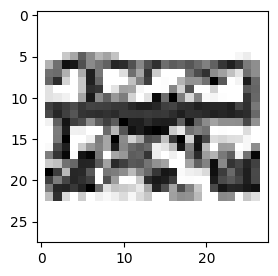

In [18]:
image_, label_ = next(ds_iter)

# print ( image_ )
print ( label_)

fig = plt.figure( figsize=(3,3) )
plt.imshow( image_, cmap='binary' )

In [19]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomRotation(0.05)
    ]
)

ds_aug = ds.map( lambda X, y: ( data_augmentation( X ), y ) )
ds_aug_iter = iter(ds_aug)

2025-05-19 19:53:38.600948: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 313600000 exceeds 10% of free system memory.


tf.Tensor(8, shape=(), dtype=uint8)


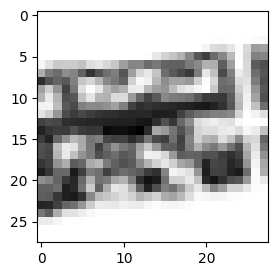

In [20]:
image_, label_ = next(ds_aug_iter)

# print ( image_ )
print ( label_)

fig = plt.figure( figsize=(3,3) )
plt.imshow( image_, cmap='binary' )

In [21]:
ds = tf.data.Dataset.from_tensor_slices( (X_train_scaled, y_train) )
ds_size = len(ds)
print ( ds_size )

50000


2025-05-19 19:53:39.051261: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 313600000 exceeds 10% of free system memory.


In [22]:
ds_aug = ( ds.map( lambda X, y: ( data_augmentation( X, training=True ), y ) )
             .batch( batch_size=batch_size )
             .prefetch( tf.data.AUTOTUNE )
             )
print ( len(ds_aug) )

1563


In [23]:
epochs = 30
if generate_images:
    history = model.fit( ds_aug, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
else:
    # history = model.fit( X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks_ )
    history = model.fit( X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )

Epoch 1/30


I0000 00:00:1747695225.805549   16127 service.cc:148] XLA service 0x7f2c800037f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747695225.805594   16127 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-05-19 19:53:46.059383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747695226.861194   16127 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-05-19 19:53:48.158263: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6890', 176 bytes spill stores, 176 bytes spill loads

2025-05-19 19:53:48.306173: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6890', 528 bytes spill sto

   5/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.1445 - loss: 31.7519  

I0000 00:00:1747695236.435064   16127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4546 - loss: 3.7823  

2025-05-19 19:55:01.186336: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6890', 176 bytes spill stores, 176 bytes spill loads



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 94s 49ms/step - accuracy: 0.4548 - loss: 3.7785 - val_accuracy: 0.6524 - val_loss: 1.2754 - learning_rate: 0.0100
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.7017 - loss: 0.9626 - val_accuracy: 0.7364 - val_loss: 0.8749 - learning_rate: 0.0079
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.7617 - loss: 0.7907 - val_accuracy: 0.7949 - val_loss: 0.7074 - learning_rate: 0.0063
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accuracy: 0.8022 - loss: 0.6715 - val_accuracy: 0.8257 - val_loss: 0.6085 - learning_rate: 0.0050
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.8243 - loss: 0.6035 - val_accuracy: 0.8591 - val_loss: 0.5001 - learning_rate: 0.0040
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.8379 - loss: 0.5546 - val_accuracy: 0.8315 - val_loss: 0.5577 - learning_rate: 0.0032
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.8544 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
# score = model.evaluate( X_valid, y_valid )
score = model.evaluate( X_valid_scaled, y_valid )
print( score )

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9171 - loss: 0.2881
[0.29077011346817017, 0.9165999889373779]


In [25]:
# score = model.evaluate( X_test, y_test )
score = model.evaluate( X_test_scaled, y_test )
print( score )

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9069 - loss: 0.3205
[0.3143596947193146, 0.9072999954223633]


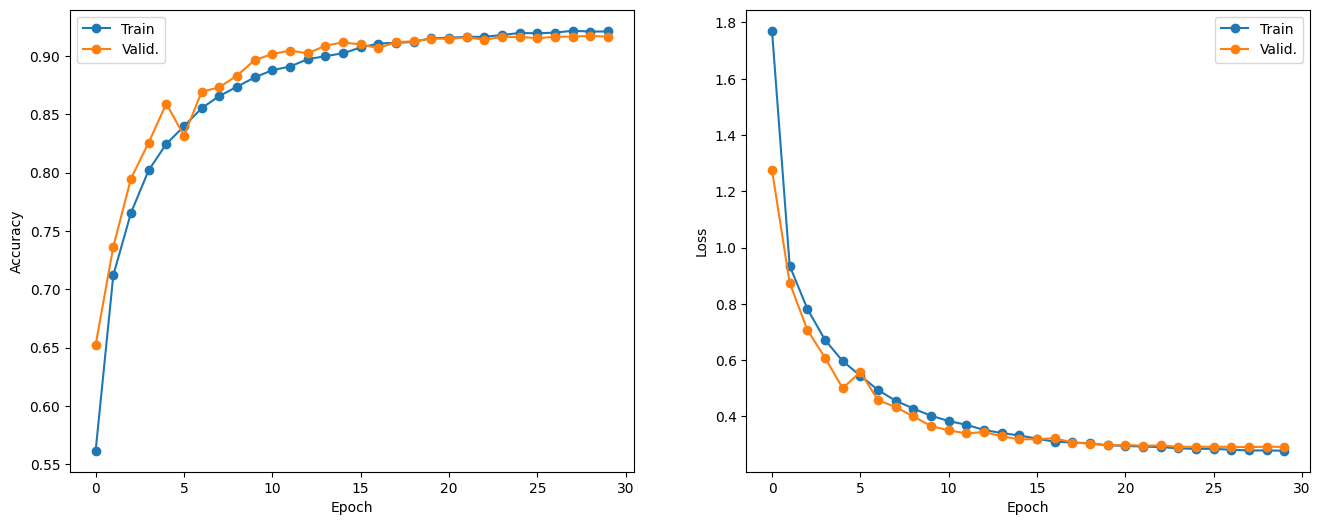

In [26]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend( loc='best' )
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend( loc='best' )

In [27]:
y_test_proba = model.predict( X_test_scaled )
# y_test_proba = model.predict( X_test )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
[[1.4298141e-07 4.1260901e-07 4.3554376e-08 ... 1.9339409e-03
  4.3563762e-08 9.9793196e-01]
 [2.4571363e-04 3.4605480e-07 9.9901843e-01 ... 9.8591361e-12
  1.3994151e-07 3.0145764e-10]
 [1.7251291e-07 9.9999058e-01 4.4154813e-08 ... 3.4803656e-11
  3.9998622e-06 1.3127180e-09]
 ...
 [6.8618680e-11 2.2074211e-14 1.5033319e-12 ... 3.9119810e-12
  1.0000000e+00 1.1633391e-12]
 [5.0930728e-05 9.9980551e-01 1.5984182e-05 ... 1.4119428e-08
  2.1512626e-06 4.9588156e-09]
 [3.3031887e-04 4.4597957e-07 7.2189118e-06 ... 1.0213108e-01
  9.8741958e-03 7.3686434e-04]]
[9 2 1 ... 8 1 5]


In [28]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.9073


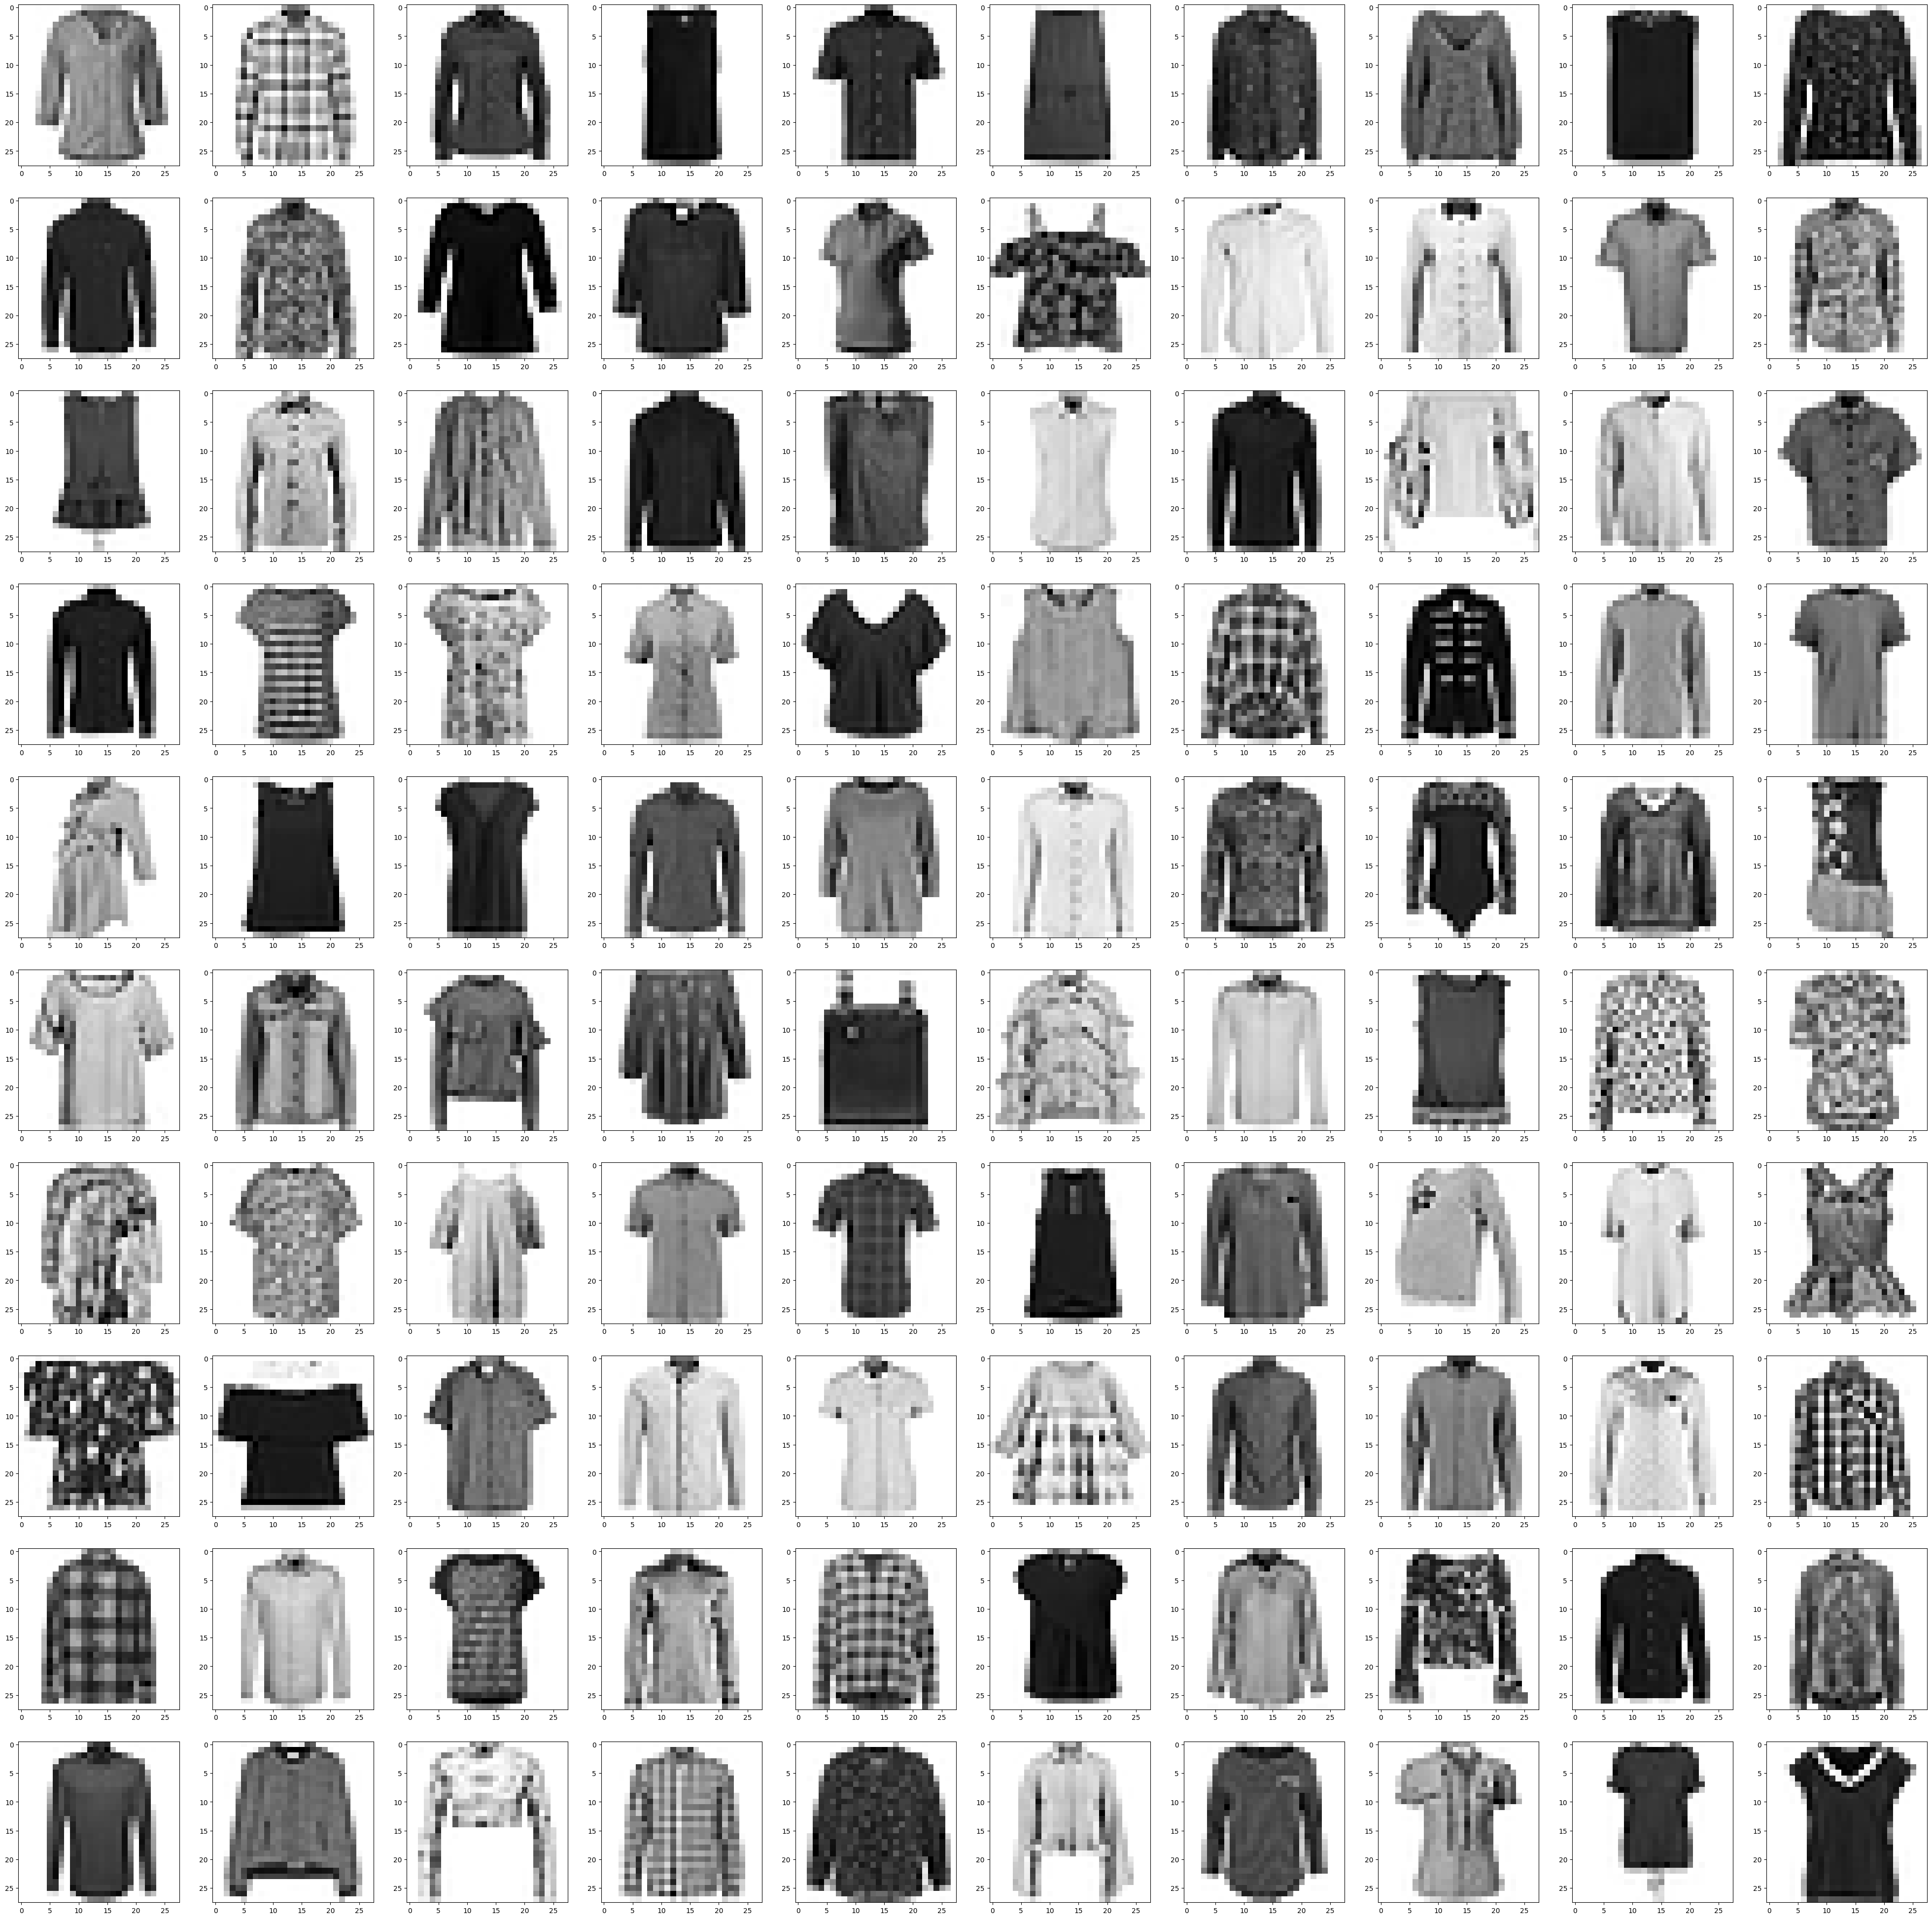

In [29]:
def plot_images( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break

        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ], cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

msk_pred_Sneaker_ = ( y_test_pred == 7 )
msk_pred_Shirt_ = ( y_test_pred == 6 )

# plot_images( X_test[ msk_pred_Sneaker_ ], 100 )
plot_images( X_test[ msk_pred_Shirt_ ], 100 )

927
T-shirt/top (0): 174
Trouser (1): 23
Pullover (2): 100
Dress (3): 106
Coat (4): 168
Sandal (5): 16
Shirt (6): 249
Sneaker (7): 24
Bag (8): 11
Ankle boot (9): 56


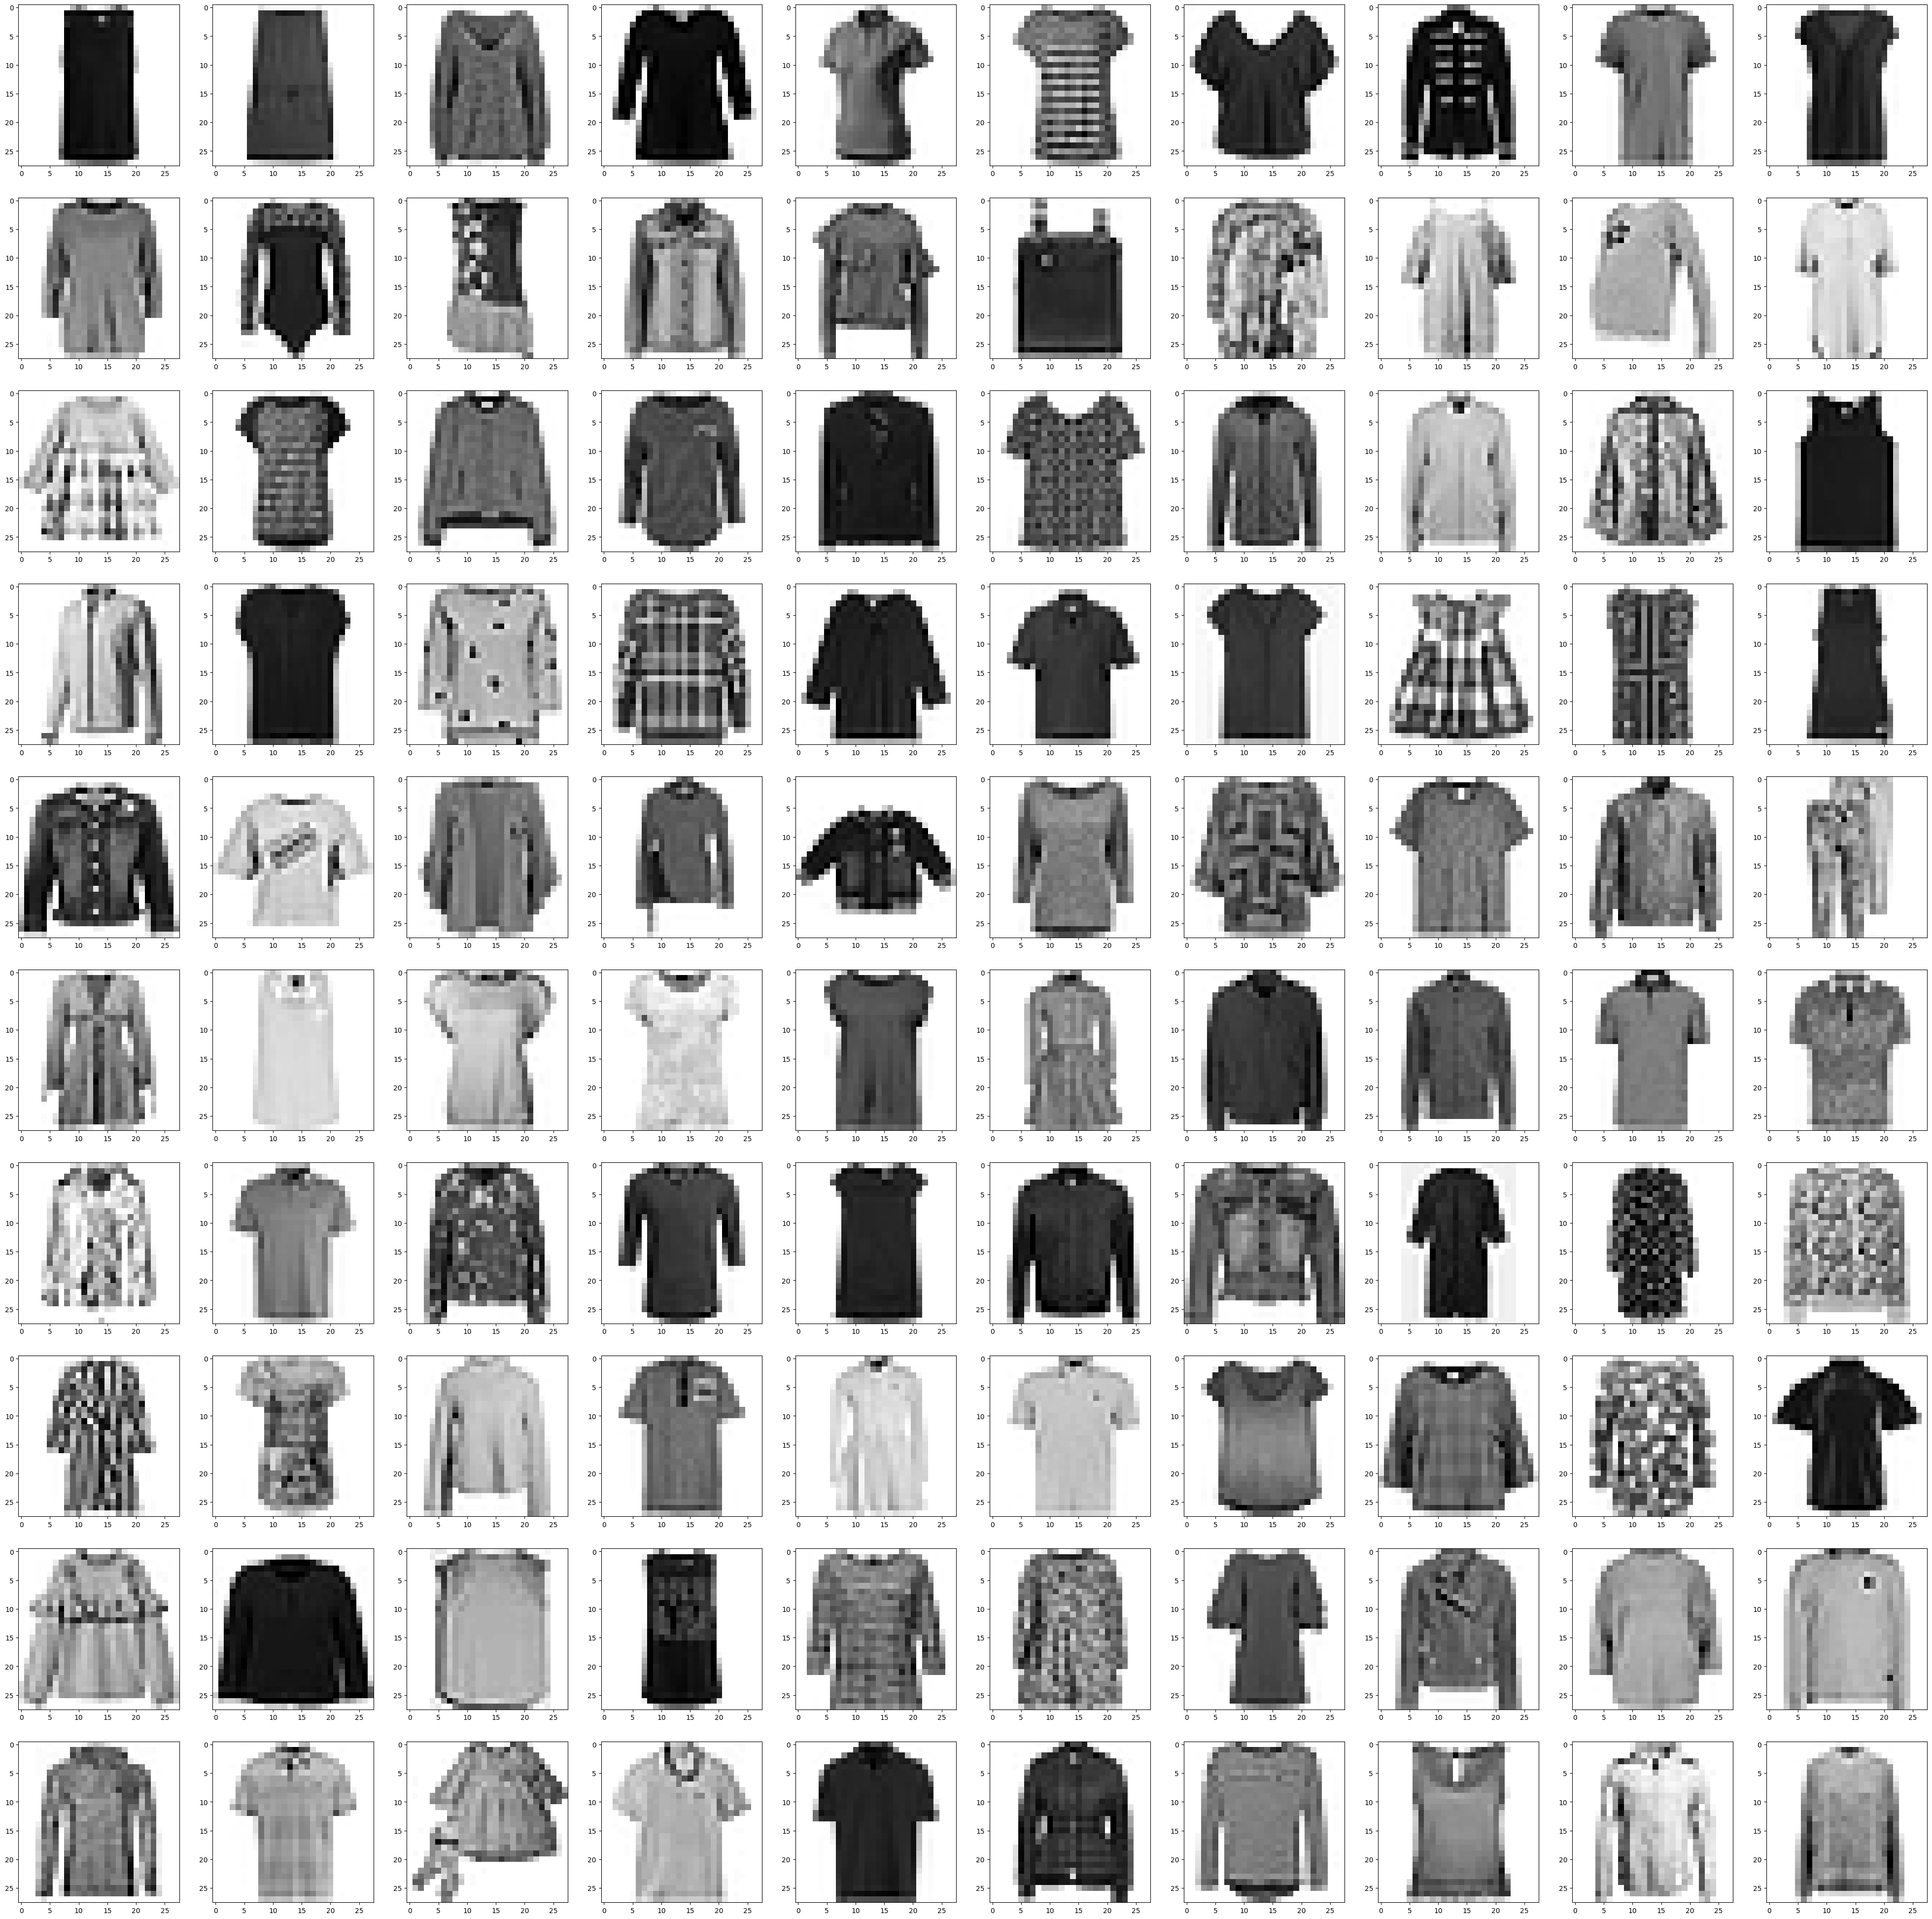

In [30]:
msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{} ({}): {}".format( class_names[label_], label_, np.sum( msk__ ) ) )

msk_error_pred_Bag_ = msk_error_ & ( y_test_pred == 8 )
msk_error_pred_Shirt_ = msk_error_ & ( y_test_pred == 6 )

# plot_images( X_test[ msk_error_ ], 100 )
# plot_images( X_test[ msk_error_pred_Bag_ ], 100 )
plot_images( X_test[ msk_error_pred_Shirt_ ], 100 )